In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyCloudy as pc

In [ ]:
pc.config.cloudy_exe = 'cloudy.exe'

In [ ]:
# Create the directory 
models_dir = "../SIGNALS_Models"
try: 
    os.makedirs(models_dir)
except OSError:
    if not os.path.isdir(models_dir):
        raise

In [ ]:
pc.print_make_file(models_dir)

In [21]:
name = 'M1'
c_input = pc.CloudyInput('{0}/{1}'.format(models_dir, name))
c_input.set_BB(Teff = 50000., lumi_unit = 'q(H)', lumi_value = 48)
c_input.set_cste_density(2., ff = 1.)
c_input.set_radius(r_in = 15.)
c_input.set_abund(predef = 'ism')
c_input.set_distance(dist=1., unit='kpc', linear=True)
options = ('no molecules',
           'no level2 lines',
           'no fine opacities',
           'atom h-like levels small',
           'atom he-like levels small',
           'element limit off -7',
            )
c_input.set_other(options)
c_input.print_input()

In [22]:
!cat ../SIGNALS_Models/M1.in

cat: ../SIGNALS_Models/M1.in: No such file or directory


In [ ]:
c_input.run_cloudy()

In [ ]:
pc.log_.level=3
M1 = pc.CloudyModel('{0}/{1}'.format(models_dir, name))
# A warning is issued because no emission line file is found. 
# This is a normal behaviour, we didn't set it.

In [ ]:
M1.print_stats()

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(12,4))
x = M1.depth/np.max(M1.depth)
axes[0].plot(x, M1.te)
axes[0].set_ylabel('Te [K]')
axes[1].plot(x, M1.get_ionic('O', 1))
axes[1].set_ylabel('O+/O')
axes[1].set_ylim(0,1)
axes[2].plot(x, M1.get_ionic('O', 2))
axes[2].set_ylabel('O++/O')
axes[2].set_ylim(0,1)
f.tight_layout()

In [ ]:
options = ('no molecules',
           'no level2 lines',
           'no fine opacities',
           'atom h-like levels small',
           'atom he-like levels small',
           'element limit off -7',
            )
from pyCloudy.utils.physics import abund_Asplund_2009

def get_R_in_Q0(logU, fr, NH=100, ff=1.0):
    c = pc.CST.CLIGHT
    U_mean = 10**logU
    w = (1 + fr**3.)**(1./3) - fr
    alpha_B = 2.6e-13
    Q0 = 4. * np.pi * c**3 * U_mean**3 / (3. * NH * ff**2 * alpha_B**2 * w**3)
    R_str = (3. * Q0 / (4 * np.pi * NH**2 * alpha_B * ff))**(1./3)
    R_in = fr * R_str
    return R_in, Q0

def make_mod(name, logU, ab_O):
    NH = 100
    ff = 0.1
    fr = 3.00
    R_in, Q0 = get_R_in_Q0(logU, fr=fr, NH=NH, ff=ff)
    c_input = pc.CloudyInput('{0}/{1}'.format(models_dir, name))
    c_input.set_BB(Teff = 50000., lumi_unit = 'q(H)', lumi_value = np.log10(Q0))
    c_input.set_cste_density(np.log10(NH), ff = ff)
    c_input.set_radius(r_in = np.log10(R_in))
    abund = abund_Asplund_2009.copy()
    delta_O = ab_O - 12 - abund['O']
    for elem in abund:
        if elem != 'He':
            abund[elem] += delta_O
    c_input.set_abund(ab_dict = abund)
    #c_input.set_grains('Orion {}'.format(10**delta_O))
    c_input.set_distance(dist=1., unit='kpc', linear=True)
    c_input.set_other(options)
    c_input.set_stop(('temperature off', 'pfrac 0.02'))
    c_input.set_emis_tab(['H  1  4861.33A', 'H  1  6562.81A', 
                          'N  2  6583.45A', 'O  3  5006.84A'])
    c_input.print_input()

In [ ]:
def set_models(dir_, model_name):
    emis_tab = ['H  1  4861.33A',
            'H  1  6562.81A',
            'Ca B  5875.64A',
            'N  2  6583.45A',
            'O  1  6300.30A',
            'O  2  3726.03A',
            'O  2  3728.81A',
            'O  3  5006.84A',
            'BLND  4363.00A'
            ]
    a = 2.
    b = 1.0
    thetas = np.linspace(0., 90., 6)
    thetas_rad = np.pi / 180. * thetas
    fact_elli = a * b / np.sqrt((b * np.sin(thetas_rad))**2 + (a * np.cos(thetas_rad))**2)
    rs_in = 16.5 + np.log10(fact_elli)
    densities = 4 - np.log10(fact_elli) * 2
    distance = 1.
    
    model = pc.CloudyInput()
    model.set_BB(80000., 'q(H)', 47.3)
    model.set_grains()
    model.set_emis_tab(emis_tab)
    model.set_distance(dist=distance, unit='kpc', linear=True)

    for theta, r_in, density in zip(thetas, rs_in, densities):
        model.model_name = '{0}/{1}_{2:.0f}'.format(dir_, model_name,theta)
        model.set_cste_density(density)
        model.set_radius(r_in)
        model.set_theta_phi(theta)
        model.print_input(to_file = True, verbose = False)


In [23]:
model_name = "M3D_1"
pc.log_.level = 3

In [ ]:
set_models(models_dir, model_name)

In [ ]:
pc.run_cloudy(dir_ = models_dir, n_proc = 6, model_name = model_name, use_make = True)

In [24]:
pc.log_.level = 2
list_of_models = pc.load_models('{0}/{1}'.format(models_dir, model_name), 
                                 list_elem=['H', 'He', 'C', 'N', 'O'],  
                                 read_cont = False, read_grains = False)

In [50]:
dim = 101
n_cut = int((dim-1) /2)
proj_axis = 0
m3d = pc.C3D(list_of_models, dims = [dim, dim, dim], angles = [45,45,0], plan_sym = True)
M = m3d.m[0]

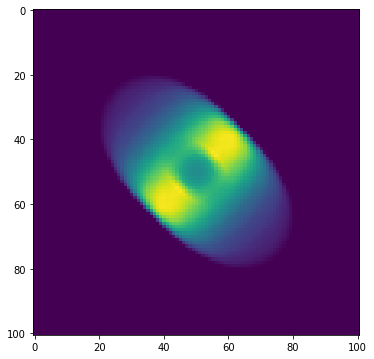

In [51]:
# plot the image of the OIII emission
f, ax = plt.subplots(figsize=(6,6))
ax.imshow(m3d.get_emis('O__3_500684A').sum(0));

In [52]:
from pyCloudy.utils.astro import conv_arc
dist = m3d.m[0].distance
arcsec = lambda cm: conv_arc(dist=dist, dist_proj=cm)

def make_mask(M, ap_center=[0., 0.], ap_size=[1., 1.]):
    """
    This returns a mask (values between 0. and 1.) to be multiplied to the image to take the flux passing through an aperture.
    An pc.C3D object named M_sphere must exist outside theis function
    """    
    x_arc = arcsec(M.cub_coord.x_vec)
    y_arc = arcsec(M.cub_coord.y_vec)
    z_arc = arcsec(M.cub_coord.z_vec)
    X, Y = np.meshgrid(y_arc, x_arc)
    bool_mask = ((X > ap_center[0] - ap_size[0]/2.) & 
            (X <= ap_center[0] + ap_size[0]/2.) & 
            (Y > ap_center[1] - ap_size[1]/2.) & 
            (Y <= ap_center[1] + ap_size[1]/2.))
    mask = np.zeros_like(X)
    mask[bool_mask] = 1.0
    return mask

In [53]:
# we define the mask. Can be change to see the effect of the aperture on line intensities
mask = make_mask(m3d, ap_center=[0., 2.], ap_size=[50, 2.5])

In [58]:
mask.shape

(101, 101)

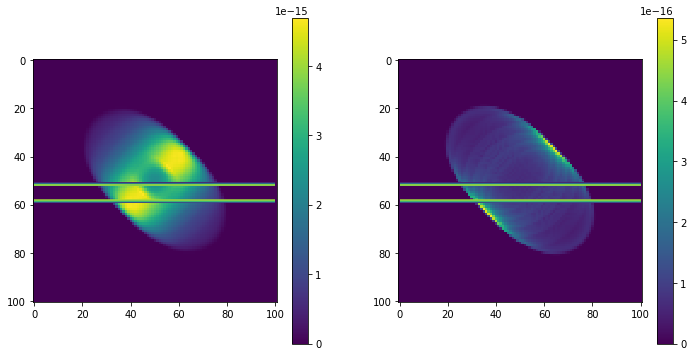

In [64]:
# We plot the OIII image and overplot the mask.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
im1 = ax1.imshow(m3d.get_emis('O__3_500684A').sum(0), interpolation='None')
im2 = ax2.imshow(m3d.get_emis('N__2_658345A').sum(0), interpolation='None')
f.colorbar(im1, ax=ax1)
f.colorbar(im2, ax=ax2)
ax1.contour(mask)
ax2.contour(mask);

In [65]:
# Hbeta is computed for the whole object and throught the aperture
Hb_tot = (m3d.get_emis('H__1_486133A')*m3d.cub_coord.cell_size).sum()
Hb_slit = ((m3d.get_emis('H__1_486133A')*m3d.cub_coord.cell_size).sum(1) * mask).sum()
print('{:.3e} {:.3e}'.format(Hb_tot, Hb_slit))

8.990e+34 1.848e+34


In [68]:
# For every line, we compute the intensity for the whole object and throught the aperture.
# We also print out the difference due to the slit.
for label in m3d.m[0].emis_labels:
    I_tot = (m3d.get_emis(label).sum()*m3d.cub_coord.cell_size) / Hb_tot
    I_slit = ((m3d.get_emis(label).sum(1) * mask).sum()*m3d.cub_coord.cell_size) / Hb_slit
    print('line: {0:12s} I/Ib Total: {1:7.4f} I/Ib Slit: {2:7.4f} Delta: {3:4.1f}%'.format(label, I_tot, I_slit, 
                                                                                           (I_slit-I_tot)/I_tot*100))

line: H__1_486133A I/Ib Total:  1.0000 I/Ib Slit:  1.0000 Delta:  0.0%
line: H__1_656281A I/Ib Total:  2.7894 I/Ib Slit:  2.7877 Delta: -0.1%
line: CA_B_587564A I/Ib Total:  0.1522 I/Ib Slit:  0.1487 Delta: -2.3%
line: N__2_658345A I/Ib Total:  0.5986 I/Ib Slit:  0.4424 Delta: -26.1%
line: O__1_630030A I/Ib Total:  0.0613 I/Ib Slit:  0.0444 Delta: -27.5%
line: O__2_372603A I/Ib Total:  0.6784 I/Ib Slit:  0.4826 Delta: -28.9%
line: O__2_372881A I/Ib Total:  0.3355 I/Ib Slit:  0.2281 Delta: -32.0%
line: O__3_500684A I/Ib Total: 10.8231 I/Ib Slit: 10.8182 Delta: -0.0%
line: BLND_436300A I/Ib Total:  0.0710 I/Ib Slit:  0.0706 Delta: -0.6%
